In [17]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib as plt
import scipy
import numpy as np
import pandas as pd
import json
import re

In [2]:
def clean_text(df):
    punc = re.compile(r"[\n,!\?\’'\+:\"\.\$&@#/\(\)\[\]\|\{\}]")
    nonwords = re.compile('^[^a-zA-Z0-9]+$')
    links = re.compile(r"https")
    
    df['body'] = df['body'].str.lower().replace('\n','',regex=True).str.replace('’',"'",regex=True).str.replace(punc,'',regex=True).str.strip()
    df = df[~df['body'].str.contains(links)]
    df = df[~df['body'].str.contains(nonwords)]
    df = df[df['body']!='']
    df['tokenized'] = df['body'].str.split(' ')
    return df

def freqs(df):
    df = df.explode('tokenized')
    freqs = df['tokenized'].value_counts().to_dict()
    STOPWORDS.update({punc.sub('',x) for x in STOPWORDS})
    new_freqs = {word:freq for (word,freq) in freqs.items() if word not in STOPWORDS}
    return new_freqs

In [ ]:
doomer_df = pd.read_json("Data/r_doomer_scraped.json", lines=True)

In [5]:
# changing the type col
doomer_df = doomer_df.rename({"_type": "type"}, axis="columns")
doomer_df = doomer_df.replace(to_replace="snscrape.modules.reddit.Submission", value="post")
doomer_df = doomer_df.replace(to_replace="snscrape.modules.reddit.Comment", value="comment")

In [12]:
doomer_posts = doomer_df[doomer_df["type"] == "post"]
doomer_posts = doomer_posts.dropna(subset=["selftext"])

In [ ]:
doomer_posts = doomer_posts.drop(["body"], axis=1)

In [22]:
doomer_posts = doomer_posts.drop(["index", "type", "parentId", "subreddit", "link"], axis=1)

In [21]:
doomer_posts = doomer_posts.reset_index()

In [15]:
doomer_posts['text_len'] = doomer_posts['selftext'].apply(len)

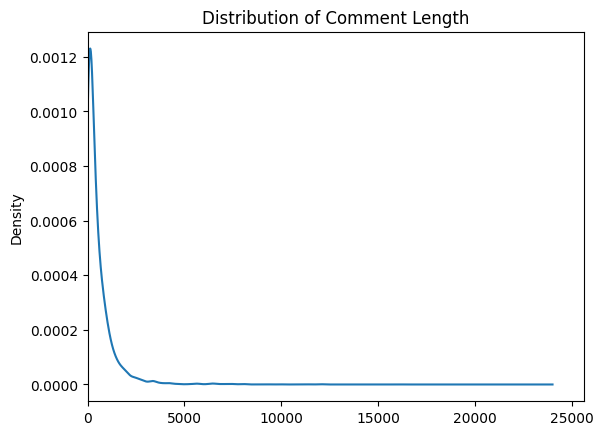

In [19]:
plt2 = doomer_posts['text_len'].plot(kind='kde',
    title="Distribution of Comment Length",
    xlabel='Comment Length',
    xlim=0)

In [20]:
doomer_posts = doomer_posts[doomer_posts["text_len"] >= 500]

In [23]:
cloud = WordCloud(stopwords=STOPWORDS,height=1000,width=2000).generate_from_text(''.join(doomer_posts['selftext']))

In [ ]:
newfreqs.pop("")

In [ ]:
punc = re.compile(r"[\n,!\?\’'\+:\"\.\$&@#/\(\)\[\]\|\{\}]")
plt.figure(figsize=(8,5),dpi=200)
plt.axis('off')
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
plt.figure(figsize=(7,5),dpi=400)
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
df['body_length'] = df['body'].apply(len)

In [ ]:
plt2 = doomer_df['text_len'].plot(kind='kde',
    title="Distribution of Comment Length",
    xlabel='Comment Length',
    xlim=0)

In [ ]:
df[df['body_length']>500]['body']

In [ ]:
df['tokenized'] = df['body'].astype(str).str.lower().str.split(" ")
df = df.explode('tokenized')
freqs = df['tokenized'].value_counts().to_dict()
newfreqs = {k:v for k,v in freqs.items() if k not in STOPWORDS}


df = clean_text(df)

In [10]:
doomer_comments.assign(text_len=doomer_comments['body'].astype(str).map(len))
doomer_posts.assign(text_len=doomer_posts['selftext'].astype(str).map(len))

doomer_df = pd.concat([doomer_posts, doomer_comments])

In [12]:
doomer_df['te']

,type,author,body,date,id,parentId,subreddit,url,link,selftext,title
34,post,Fuck_Doomer,NaN,2022-10-30 08:04:25+00:00,t3_yh8k5g,NaN,doomer,https://old.reddit.com/r/doomer/comments/yh8k5...,None,"**Hello guys :D - Before i start this text, i ...",A little jorney into the life of a Doomer
41,post,DonovanPeredo,NaN,2022-10-30 07:02:07+00:00,t3_yh7amo,NaN,doomer,https://old.reddit.com/r/doomer/comments/yh7am...,None,I have a problem and I would use a different p...,I need an advise please
47,post,Alex_DK,NaN,2022-10-30 05:29:02+00:00,t3_yh5igs,NaN,doomer,https://old.reddit.com/r/doomer/comments/yh5ig...,None,Just lost one of my absolute favorite music ar...,Loss of an artist.
51,post,SoldierSam1,NaN,2022-10-30 04:44:43+00:00,t3_yh4r5q,NaN,doomer,https://old.reddit.com/r/doomer/comments/yh4r5...,None,I live in Phoenix and crime has gotten worse &...,My City Is Hell
53,post,MontiacMcgee,NaN,2022-10-30 04:40:44+00:00,t3_yh4ony,NaN,doomer,https://old.reddit.com/r/doomer/comments/yh4on...,None,END IT END IT END IT\n\nYOUR IN FUCKING HELL J...,JUST FUCKING END IT ALREADY
...,...,...,...,...,...,...,...,...,...,...,...
7038,comment,french_doomer,no... sadly,2022-09-26 20:48:41+00:00,t1_iq0ptm3,t1_iq0i3mi,doomer,https://old.reddit.com/r/doomer/comments/xosrg...,NaN,NaN,NaN
7039,comment,L0tt1ce,One of the reasons that post-apocalyptic ficti...,2022-09-26 20:36:51+00:00,t1_iq0nxzp,t3_xou2i8,doomer,https://old.reddit.com/r/doomer/comments/xou2i...,NaN,NaN,NaN
7040,comment,french_doomer,"you ave the same problem than me i think, we a...",2022-09-26 20:16:52+00:00,t1_iq0kr39,t3_xol0kj,doomer,https://old.reddit.com/r/doomer/comments/xol0k...,NaN,NaN,NaN
7041,comment,doomer-driver,Literally me,2022-09-26 20:12:11+00:00,t1_iq0k0d5,t3_xo6koa,doomer,https://old.reddit.com/r/doomer/comments/xo6ko...,NaN,NaN,NaN


In [11]:
ave_txt_len = int(doomer_df[['text_len']].mean(axis=0))
shortest_txt_len = int(min(doomer_df['text_len']))
longest_txt_len = int(max(doomer_df['text_len']))

KeyError: "None of [Index(['text_len'], dtype='object')] are in the [columns]"

In [ ]:
plt2 = doomer_df['text_len'].plot(kind='kde',
    title="Distribution of Comment Length",
    xlabel='Comment Length',
    xlim=0)

In [14]:
lonely_comments = doomer_comments[doomer_comments['body'].str.contains('lonely')]


In [15]:
lonely_posts = doomer_posts[doomer_posts['selftext'].astype(str).str.contains('lonely')]

In [17]:
lonely_posts.reset_index(drop=True,inplace=True)

In [22]:
import re

In [41]:
import nltk

In [ ]:
nltk.

In [24]:
lonely = re.compile(".{40}lonely.{40}")

In [29]:
from collections import Counter

In [36]:
df = pd.Series(Counter(text.split()))

In [40]:
df.nlargest(25)

and        73
I          49
to         49
her        44
a          35
she        28
was        27
the        26
in         21
that       14
being      14
with       14
for        14
time       13
it         12
me         12
be         11
of         11
had        11
She        11
at         11
is         10
talking    10
this        9
all         9
dtype: int64

In [34]:
Counter(text.split())

Counter({'To': 1,
         'explain': 1,
         'my': 4,
         'story': 2,
         'I': 49,
         'will': 1,
         'start': 1,
         'from': 2,
         'the': 26,
         'beginning.': 1,
         'met': 4,
         'a': 35,
         'girl': 4,
         'online': 4,
         'and': 73,
         'we': 7,
         'really': 7,
         'hit': 4,
         'it': 12,
         'off.': 1,
         'know': 6,
         'meeting': 2,
         'girls': 1,
         'is': 10,
         'considered': 1,
         'cringy': 1,
         'pathetic': 1,
         'but': 3,
         'have': 6,
         'mental': 1,
         'impairment.': 1,
         'Aspergers': 1,
         'disorder': 2,
         'which': 2,
         'basically': 3,
         'condition': 1,
         'that': 14,
         'makes': 1,
         'you': 2,
         'hard': 3,
         'time': 13,
         'socialising': 1,
         'being': 14,
         'comfortable': 1,
         'around': 2,
         'others.': 1,
         'So

In [28]:
text.split()

['To',
 'explain',
 'my',
 'story',
 'I',
 'will',
 'start',
 'from',
 'the',
 'beginning.',
 'I',
 'met',
 'a',
 'girl',
 'online',
 'and',
 'we',
 'really',
 'hit',
 'it',
 'off.',
 'I',
 'know',
 'meeting',
 'girls',
 'online',
 'is',
 'considered',
 'cringy',
 'and',
 'pathetic',
 'but',
 'I',
 'have',
 'a',
 'mental',
 'impairment.',
 'I',
 'have',
 'Aspergers',
 'disorder',
 'which',
 'is',
 'basically',
 'a',
 'condition',
 'that',
 'makes',
 'you',
 'have',
 'a',
 'really',
 'hard',
 'time',
 'socialising',
 'and',
 'being',
 'comfortable',
 'around',
 'others.',
 'So',
 'to',
 'finally',
 'be',
 'able',
 'to',
 'hit',
 'it',
 'of',
 'with',
 'a',
 'girl',
 'that',
 'looked',
 'very',
 'attractive',
 'to',
 'me',
 'and',
 'easy',
 'to',
 'talk',
 'to',
 'felt',
 'really',
 'nice.',
 'We',
 'hit',
 'things',
 'off',
 'so',
 'well',
 'that',
 'we',
 'decide',
 'to',
 'be',
 'in',
 'a',
 'online',
 'relationship',
 'together',
 'and',
 'decided',
 'we',
 'where',
 'in',
 'love',
 

In [26]:
lonely.findall(text)

[' many hours being there when they where lonely and had nobody and locked in some shi*t']

In [25]:
text = lonely_posts.head()['selftext'][0]